# DSI Project 4: West Nile Virus Prediction

## Problem Statement:

Due to the recent epidemic of West Nile Virus in Chicago, we need to deploy pesticides throughout the city cost-effectively (as pesticides are expensive) and safely without causing hazard to public health.<br>
Given weather, location, testing, and spraying data, the task is to predict where and when different species of mosquitos will be tested positive for West Nile Virus. Mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations. Success is evaluated on area under the ROC curve between the predicted probability that West Nile Virus is present and the observed outcomes.


## Executive Summary
---
### Contents:
- [Data Description](#Data-Description)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Feature Engineering](#Feature-Engineering)
- [Model Evaluation & Kaggle Prediction Scoring](#Model-Evaluation-&-Kaggle-Prediction-Scoring)
- [Conclusion](#Conclusion)

# Data Description

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort.

There are in total 4 datasets provided:
- Train Dataset (May-Oct 2007, May-Oct 2009, Jun-Sep 2011, Jun-Sep 2013) 
- Test Dataset (Jun-Sep 2008, Jun-Oct 2010, Jun-Sep 2012, Jun-Oct 2014)
- Weather Dataset (May-Oct 2007-2014)
- Spray Dataset (Aug-Sep 2011, Jul-Sep 2013)    

## Data Cleaning & EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV


%matplotlib inline

pd.set_option('display.max_rows', 100) # to look at more rows of data later
pd.set_option('display.max_columns', 100) # to expand columns view so that all can be seen later

Cleaning of the Weather Data has been done, for details of the cleaning process you may refer [here](./weather_cleaned.ipynb). <br>
You may refer to the clean csv [here](../dataset/weather_final.csv)

In [2]:
# Load dataset
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
weather_df = pd.read_csv('../dataset/weather_final.csv')
spray_df=pd.read_csv('../dataset/spray.csv')
street_map = gpd.read_file('../dataset/geo_export_6f337adc-3081-4800-8a83-2e6ce1971179.shx')

In [3]:
# Print shape of dataset
print(train_df.shape)
print(test_df.shape)

(10506, 12)
(116293, 11)


There are more test data (92%) than train data (8%).

In [4]:
# Print columns
print(train_df.columns)
print(test_df.columns)

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')
Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')


Test Dataset comprises all features in Train Datasets except for 'NumMosquitos' and 'WnvPresent'

In [5]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


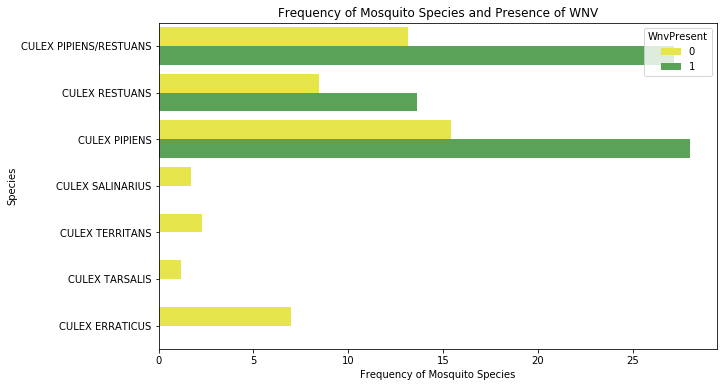

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(y='Species', x='NumMosquitos', hue='WnvPresent', data=train_df, palette='Set1_r',ci=None)
plt.title('Frequency of Mosquito Species and Presence of WNV')
plt.xlabel('Frequency of Mosquito Species');

In [7]:
# Check date duration in train data
pd.to_datetime(train_df['Date'],format='%Y-%m-%d').dt.strftime("%Y-%m").value_counts().sort_index()

2007-05      25
2007-06     176
2007-07     575
2007-08    2050
2007-09     774
2007-10     211
2009-05      59
2009-06     578
2009-07     755
2009-08     374
2009-09     418
2009-10      65
2011-06     381
2011-07     640
2011-08     493
2011-09     540
2013-06     436
2013-07     636
2013-08     834
2013-09     486
Name: Date, dtype: int64

Train Dataset comprises data for:
- May-Oct 2007
- May-Oct 2009
- Jun-Sep 2011
- Jun-Sep 2013


In [8]:
# Check if train data is collected on a consistent basis throughout the period?
d = pd.concat([train_df[['Date']] ,pd.to_datetime(train_df['Date']).dt.to_period("M")], axis=1)
d.columns = ['date','year_month']
d.drop_duplicates().groupby(by=['year_month']).count()

,date
year_month,
2007-05,1
2007-06,3
2007-07,6
2007-08,13
2007-09,8
2007-10,2
2009-05,1
2009-06,9
2009-07,7


Train Data collection frequency is not consistent across months.<br>
ie. In May 2007 , there is only observation on one day and in Aug 2007, there are 13 observation days.

In [9]:
train_df_copy=train_df.copy()

In [10]:
# fig, ax = plt.subplots(figsize=(8,8))
# street_map.plot(ax = ax);

# Compile list of observation of each geo point
geometry = [Point(xy) for xy in zip(train_df['Longitude'], train_df['Latitude'])]
geometry[:3]

# Set up Chicago coordinates using EPSG coordinate ref. system
crs = {'init': 'epsg:4326'}

# # Convert train dataframe to geo dataframe
geo_df = gpd.GeoDataFrame(train_df_copy,
                          crs = crs,
                          geometry = geometry)
# #geo_df.head(2)

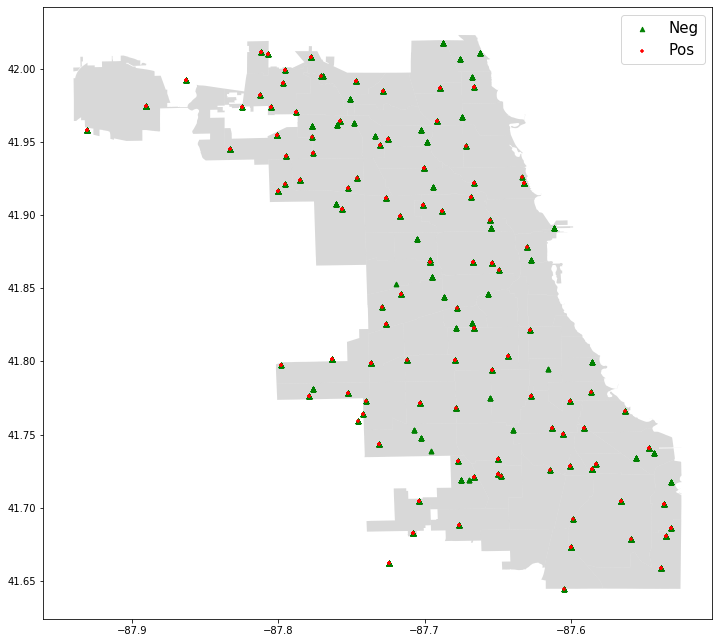

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=.3, color='grey');
geo_df[geo_df['WnvPresent'] == 0].plot(ax=ax, markersize=20, color='g', marker='^', label='Neg')
geo_df[geo_df['WnvPresent'] == 1].plot(ax=ax, markersize=20, color='r', marker='+', label='Pos')
plt.legend(prop={'size':15});

In [12]:
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [13]:
# Check date duration in test data
pd.to_datetime(test_df['Date'],format='%Y-%m-%d').dt.strftime("%Y-%m").value_counts().sort_index()

2008-06     3633
2008-07    10935
2008-08     8578
2008-09     7352
2010-06     6075
2010-07    12252
2010-08     8520
2010-09     8495
2010-10     1215
2012-06     4874
2012-07     6336
2012-08    11029
2012-09     4876
2014-06     4896
2014-07     6142
2014-08     4988
2014-09     4889
2014-10     1208
Name: Date, dtype: int64

Test Dataset comprises data for:
- Jun-Sep 2008
- Jun-Oct 2010
- Jun-Sep 2012
- Jun-Oct 2014

In [14]:
# Check if test data is collected on a consistent basis throughout the period?
d = pd.concat([test_df[['Date']] ,pd.to_datetime(test_df['Date']).dt.to_period("M")], axis=1)
d.columns = ['date','year_month']
d.drop_duplicates().groupby(by=['year_month']).count()

,date
year_month,
2008-06,3
2008-07,9
2008-08,7
2008-09,6
2010-06,5
2010-07,10
2010-08,7
2010-09,7
2010-10,1


Test Data collection frequency is not consistent across months.<br>
ie. In Jun 2008 , there are only observation on three day and in Jul 2010, there are 10 observation days.

In [15]:
print(train_df[train_df.duplicated()].count())

Date                      813
Address                   813
Species                   813
Block                     813
Street                    813
Trap                      813
AddressNumberAndStreet    813
Latitude                  813
Longitude                 813
AddressAccuracy           813
NumMosquitos              813
WnvPresent                813
dtype: int64


There are 813 duplicate observations in train dataset due to the test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another row in the dataset.(In short, the number of mosquito of each row are capped at 50).

In [16]:
print(test_df[test_df.duplicated()].count())

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64


There is no duplicate observations in test dataset as there's no 'NumMosquitos' in test dataset.

In [17]:
train_df.groupby(by=['Date','Address','Species','WnvPresent']).sum()

Block  \
Date       Address                                            Species                WnvPresent          
2007-05-29 1100 Roosevelt Road, Chicago, IL 60608, USA        CULEX PIPIENS/RESTUANS 0              11   
                                                              CULEX RESTUANS         0              11   
           1100 South Peoria Street, Chicago, IL 60608, USA   CULEX RESTUANS         0              11   
           1100 West Chicago Avenue, Chicago, IL 60642, USA   CULEX RESTUANS         0              11   
           1500 North Long Avenue, Chicago, IL 60651, USA     CULEX RESTUANS         0              15   
           1500 West Webster Avenue, Chicago, IL 60614, USA   CULEX RESTUANS         0              15   
           1700 West 95th Street, Chicago, IL 60643, USA      CULEX RESTUANS         0              17   
           2100 North Stave Street, Chicago, IL 60647, USA    CULEX PIPIENS/RESTUANS 0              21   
           2200 North Cannon Drive, Chicago, IL 60614, USA    CULEX PIPIENS/RESTUANS 0              22   
                                                              CULEX RESTUANS         0              22   
           2200 West 113th Street, Chicago, IL 60643, USA     CULEX PIPIENS/RESTUANS 0              22   
                                                              CULEX RESTUANS         0              22   
           2200 West 89th Street, Chicago, IL 60643, USA      CULEX PIPIENS          0              22   
                                                              CULEX RESTUANS         0              22   
           2500 West Grand Avenue, Chicago, IL 60654, USA     CULEX RESTUANS         0              25   
           4100 North Oak Park Avenue, Chicago, IL 60634, USA CULEX PIPIENS/RESTUANS 0              41   
                                                              CULEX RESTUANS         0              41   
           6200 North Mandell Avenue, Chicago, IL 60646, USA  CULEX RESTUANS         0              62   
           6500 North Oak Park Avenue, Chicago, IL 60631, USA CULEX PIPIENS/RESTUANS 0              65   
           7500 North Oakley Avenue, Chicago, IL 60645, USA   CULEX PIPIENS/RESTUANS 0              75   
           7900 West Foster Avenue, Chicago, IL 60656, USA    CULEX PIPIENS/RESTUANS 0              79   
                                                              CULEX RESTUANS         0              79   
           8900 South Carpenter Street, Chicago, IL 60620,... CULEX RESTUANS         0              89   
           North Streeter Drive, Chicago, IL 60611, USA       CULEX PIPIENS/RESTUANS 0              53   
                                                              CULEX RESTUANS         0              53   
2007-06-05 1100 Roosevelt Road, Chicago, IL 60608, USA        CULEX PIPIENS          0              11   
                                                              CULEX PIPIENS/RESTUANS 0              11   
                                                              CULEX RESTUANS         0              11   
           1100 South State Street, Chicago, IL 60605, USA    CULEX PIPIENS/RESTUANS 0              11   
           1100 West Chicago Avenue, Chicago, IL 60642, USA   CULEX RESTUANS         0              11   
           1400 North Sacramento Avenue, Chicago, IL 60622... CULEX RESTUANS         0              14   
           1500 North Long Avenue, Chicago, IL 60651, USA     CULEX RESTUANS         0              15   
           1500 West Granville Avenue, Chicago, IL 60660, USA CULEX PIPIENS/RESTUANS 0              15   
           1500 West Webster Avenue, Chicago, IL 60614, USA   CULEX PIPIENS          0              15   
                                                              CULEX PIPIENS/RESTUANS 0              15   
                                                              CULEX RESTUANS         0              15   
           1700 West 95th Street, Chicago, IL 60643, USA      CULEX P

We define unique trap observation by grouping 'Date','Address','Species','WnvPresent'.<br>
We are not considering 'NumMosquitos' as our feature as there's no ''NumMosquitos' found in test dataset.<br>There are in total 8610 unique trap observations in train dataset.

In [18]:
# Drop duplicates
train_df.drop_duplicates(subset=['Date','Address','Species','Trap','Block','WnvPresent'],inplace=True)
train_df.reset_index(inplace=True)

In [19]:
train_df.shape

(8610, 13)

In [20]:
# Check which mozzies spread WNV
train_df[train_df['WnvPresent'] == 1]['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

From train dataset it can be observed that WNV is only present in the following 3 species of Mosquitos:
- CULEX PIPIENS/RESTUANS
- CULEX PIPIENS
- CULEX RESTUANS

In [21]:
# Check if there's overlap
train_df[train_df['WnvPresent'] == 0]['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

However, the presence of any single species does not mandate the presence of WNV. 

In [22]:
# One-hot encode mozzies that spread WNV
train_species = pd.get_dummies(train_df['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]
test_species = pd.get_dummies(test_df['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]

Based on earlier observation on train dataset, only 'CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS' are found to carry WNV.<br>
We one hot encode these 3 species and for other species that does not fall in any of the 3 categories, it will be encoded as all zeroes (Other Species).

In [23]:
train_df = pd.concat([train_df,train_species],axis=1,sort=False)
test_df = pd.concat([test_df,test_species],axis=1,sort=False)

In Weather dataset, there are 2 weather stations that records weather conditions daily.<br>

We need to identify which weather station(1 or 2) is closest to each trap, and join the weather data based on the date of observation.

Distance is calculated by euclidean distance between weather stations and traps coordinate.

In [24]:
# Calculate euclidean distance of weather station from city and determine which station is nearest
# This is calculated using pythagoras theorem  
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
train_df['diststat1'] = np.sqrt((train_df['Latitude'] - 41.995) ** 2 + (train_df['Longitude'] - (-87.933)) ** 2)
train_df['diststat2'] = np.sqrt((train_df['Latitude'] - 41.786) ** 2 + (train_df['Longitude'] - (-87.752)) ** 2)
train_df['Station'] = [2 if train_df['diststat1'][i] > train_df['diststat2'][i] else 1 for i in range(train_df.shape[0])]
train_df.head(2)


,index,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station
0,0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1,0,0,0.138026,0.17566,1
1,1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0,0,1,0.138026,0.17566,1


In [25]:
# Apply for test data set

test_df['diststat1'] = np.sqrt((test_df['Latitude'] - 41.995) ** 2 + (test_df['Longitude'] - (-87.933)) ** 2)
test_df['diststat2'] = np.sqrt((test_df['Latitude'] - 41.786) ** 2 + (test_df['Longitude'] - (-87.752)) ** 2)
test_df['Station'] = [2 if test_df['diststat1'][i] > test_df['diststat2'][i] else 1 for i in range(test_df.shape[0])]
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0,0.138026,0.17566,1
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,1,0.138026,0.17566,1
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,1,0,0.138026,0.17566,1
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,0,0.138026,0.17566,1
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,0,0.138026,0.17566,1


## Feature Engineering

In [26]:
# Feature engineer to add a new column 'dateofyear', which is the day within a year.
train_df['dateofyear'] = pd.to_datetime(train_df['Date'], format='%Y-%m-%d').dt.dayofyear
test_df['dateofyear'] = pd.to_datetime(test_df['Date'], format='%Y-%m-%d').dt.dayofyear

In [27]:
# Merged weather and train/test to one dataframe
train_weather_df = pd.merge(train_df,weather_df,on=['Station','Date'])
train_weather_df.drop(axis=1,columns=['index'],inplace=True)
train_weather_df.head()
train_weather_df.to_csv('../dataset/train_weather_csv')

In [28]:
test_weather_df = pd.merge(test_df,weather_df,on=['Station','Date'])
# test_weather_df.drop(axis=1,columns=['index'],inplace=True)
test_weather_df.head()
train_weather_df.to_csv('../dataset/test_weather_csv')

In [29]:
train_weather_df.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
CULEX PIPIENS/RESTUANS      uint8
CULEX PIPIENS               uint8
CULEX RESTUANS              uint8
diststat1                 float64
diststat2                 float64
Station                     int64
dateofyear                  int64
Tmax                        int64
Tmin                        int64
Tavg                      float64
Depart                    float64
DewPoint                    int64
WetBulb                   float64
Heat                      float64
Cool                      float64
Sunrise                     int64
Sunset                      int64
CodeSum       

Text(0, 0.5, 'No of Occurance of WNV')

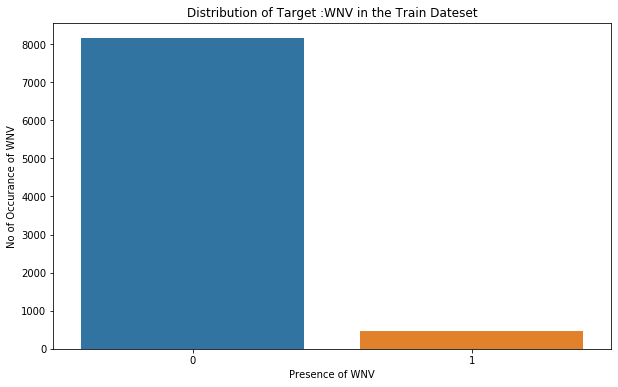

In [30]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="WnvPresent", data=train_weather_df)
plt.title('Distribution of Target :WNV in the Train Dateset')
plt.xlabel('Presence of WNV')
plt.ylabel('No of Occurance of WNV')

Unbalance distribution of target (Presence of WNV) in train datasets.<br>
We will have to stratify our target variable while doing train-test-split.

Text(0.5, 0.98, 'Wnv Counts across Months')

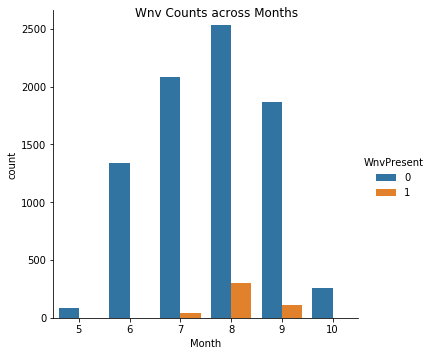

In [31]:
sns.catplot(data=train_weather_df, x="Month", kind="count", hue='WnvPresent').fig.suptitle("Wnv Counts across Months")

Presence of WNV virus is high in August.

C:\Users\User\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'WetBulb Vs Average Temperature')

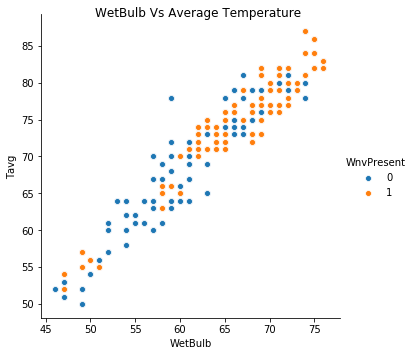

In [32]:
sns.pairplot(data=train_weather_df, x_vars='WetBulb', y_vars='Tavg', hue='WnvPresent', size=5).fig.suptitle("WetBulb Vs Average Temperature")

There's a positive correlation between Average Temperature , Wetbulb and presence of WNV.<br>
Presence of WNV is evident when Average Temperature is above 70 Degrees Fahrenheit and wetbulb is above 65 Degrees Fahrenheit. 

Text(0.5, 0.98, 'DewPoint Vs Average Temperature')

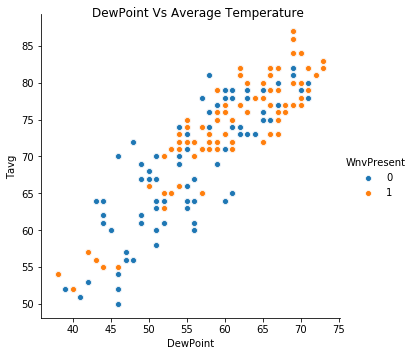

In [33]:
sns.pairplot(data=train_weather_df, x_vars='DewPoint', y_vars='Tavg', hue='WnvPresent', size=5).fig.suptitle("DewPoint Vs Average Temperature")

There's a positive correlation between Average Temperature , DewPoint and presence of WNV.<br>
Presence of WNV is evident when Average Temperature is above 70 Degrees Fahrenheit and DewPoint is above 55 Degrees Fahrenheit. 

In [34]:
# Rearrange Column Name
col_at_end=['WnvPresent']
train_weather_df=train_weather_df[[c for c in train_weather_df if c not in col_at_end]+
                                [c for c in col_at_end]]
print(train_weather_df.shape)
train_weather_df.head(2)

(8610, 38)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station,dateofyear,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,1,0,0,0.138026,0.17566,1,149,88,60,74.0,10.0,58,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0,1,0.138026,0.17566,1,149,88,60,74.0,10.0,58,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,0


In [35]:
feat = ['dateofyear','Latitude','Longitude','AddressAccuracy','CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS','Heat','Cool','WetBulb','PrecipTotal','Sunrise','Sunset','Tmin','Tmax']

X_subset = train_weather_df[feat]
y = train_weather_df['WnvPresent']
X_kaggle_subset = test_weather_df[feat]

In [36]:
X_subset.head()

,dateofyear,Latitude,Longitude,AddressAccuracy,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,Heat,Cool,WetBulb,PrecipTotal,Sunrise,Sunset,Tmin,Tmax
0,149,41.954690,-87.800991,9,1,0,0,0.0,9.0,65.0,0.0,421,1917,60,88
1,149,41.954690,-87.800991,9,0,0,1,0.0,9.0,65.0,0.0,421,1917,60,88
2,149,41.994991,-87.769279,9,0,0,1,0.0,9.0,65.0,0.0,421,1917,60,88
3,149,41.974089,-87.824812,8,1,0,0,0.0,9.0,65.0,0.0,421,1917,60,88
4,149,41.974089,-87.824812,8,0,0,1,0.0,9.0,65.0,0.0,421,1917,60,88


Applying polynomial features to get a sense of interaction terms.

In [37]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_subset)
X_kaggle_poly = poly.fit_transform(X_kaggle_subset)

In [38]:
poly_train = pd.DataFrame(X_train_poly, columns = poly.get_feature_names(X_subset.columns),index=train_weather_df.index)
poly_kaggle = pd.DataFrame(X_kaggle_poly, columns = poly.get_feature_names(X_kaggle_subset.columns),index=test_weather_df.index)

In [39]:
poly_train['WnvPresent'] = train_weather_df['WnvPresent']

In [40]:
features = np.abs(poly_train.corr()[['WnvPresent']]).sort_values(by='WnvPresent',ascending=False).head(31).T
features.columns.tolist()

['WnvPresent',
 'WetBulb Sunrise',
 'dateofyear WetBulb',
 'Sunrise Tmin',
 'dateofyear Tmin',
 'Sunrise Sunset',
 'dateofyear Tmax',
 'Sunrise Tmax',
 'dateofyear Sunset',
 'CULEX PIPIENS Cool',
 'CULEX PIPIENS Tmin',
 'CULEX PIPIENS WetBulb',
 'dateofyear Latitude',
 'dateofyear Longitude',
 'dateofyear',
 'CULEX PIPIENS Tmax',
 'CULEX PIPIENS Sunrise',
 'dateofyear CULEX PIPIENS',
 'Latitude Sunrise',
 'Longitude Sunrise',
 'Sunrise',
 'Latitude CULEX PIPIENS',
 'Longitude CULEX PIPIENS',
 'CULEX PIPIENS Sunset',
 'CULEX PIPIENS',
 'AddressAccuracy CULEX PIPIENS',
 'dateofyear Sunrise',
 'CULEX RESTUANS Sunset',
 'CULEX RESTUANS',
 'Longitude CULEX RESTUANS',
 'Latitude CULEX RESTUANS']

In [71]:
#list(poly_train.columns)

In [42]:
# # feature_list = ['dateofyear',
# #                 'Latitude', 
# #                 'Longitude',
# #                 'CULEX PIPIENS/RESTUANS',
# #                 'CULEX PIPIENS',
# #                 'CULEX RESTUANS',
# #                 'dateofyear CULEX PIPIENS/RESTUANS',
# #                 'dateofyear CULEX PIPIENS',
# #                 'dateofyear CULEX RESTUANS',
# #                 'Latitude CULEX PIPIENS/RESTUANS',
# #                 'Latitude CULEX PIPIENS',
# #                 'Latitude CULEX RESTUANS',
# #                 'Longitude CULEX PIPIENS/RESTUANS', 
# #                 'Longitude CULEX PIPIENS',
# #                 'Longitude CULEX RESTUANS',
# #                'Heat','Cool','WetBulb','PrecipTotal','Sunrise','Sunset','Tmin','Tmax']

# feature_list = ['dateofyear CULEX PIPIENS/RESTUANS',
#                'dateofyear CULEX PIPIENS',
#                'dateofyear CULEX RESTUANS',
#                'CULEX PIPIENS/RESTUANS Sunrise',
#                'CULEX PIPIENS Sunrise',
#                'CULEX RESTUANS Sunrise',
#                'Longitude CULEX PIPIENS/RESTUANS',
#                'Longitude CULEX PIPIENS',
#                'Longitude CULEX RESTUANS',
#               'WetBulb Sunrise','Sunrise']


feature_list =[
 'WetBulb Sunrise',
 'dateofyear WetBulb',
 'Sunrise Tmin',
 'dateofyear Tmin',
 'Sunrise Sunset',
 'dateofyear Tmax',
 'Sunrise Tmax',
 'dateofyear Sunset',
 'CULEX PIPIENS Cool',
 'CULEX PIPIENS Tmin',
 'CULEX PIPIENS WetBulb',
 'dateofyear Latitude',
 'dateofyear Longitude',
 'dateofyear',
 'CULEX PIPIENS Tmax',
 'CULEX PIPIENS Sunrise',
 'dateofyear CULEX PIPIENS',
 'Latitude Sunrise',
 'Longitude Sunrise',
 'Sunrise',
 'Latitude CULEX PIPIENS',
 'Longitude CULEX PIPIENS',
 'CULEX PIPIENS Sunset',
 'CULEX PIPIENS',
 'AddressAccuracy CULEX PIPIENS',
 'dateofyear Sunrise',
 'CULEX RESTUANS Sunset',
 'CULEX RESTUANS',
 'Longitude CULEX RESTUANS',
 'Latitude CULEX RESTUANS']
X = poly_train[feature_list]
X_kaggle = poly_kaggle[feature_list]

## Model Evaluation & Kaggle Prediction Scoring

We first create functions that will help us with our modelling later.

In [43]:
model_dict = {
    'ss': StandardScaler(),
    'lr': LogisticRegression(solver='lbfgs'),
    'nb': MultinomialNB(),
    'knn': KNeighborsClassifier(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(random_state=42),
    'et': ExtraTreesClassifier(),
    'ada_dt': AdaBoostClassifier(random_state=42),
    'ada_rf': AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=42),random_state=42),
    'gboost': GradientBoostingClassifier()
}

model_full = {
    'ss': 'Standard Scaler',
    'lr': 'Logistic Regression',
    'knn': 'KNearestNeighbor',
    'nb': 'Multinomial NB',
    'dt': 'Decision Tree',
    'rf': 'Random Forest',
    'et': 'Extra Tree',
    'ada_dt': 'AdaBoost - Decision Tree',
    'ada_rf': 'AdaBoost - Random Forest',
    'gboost': 'Gradient Boosting Classifier'
}

param_dict = {    
    'knn': {
        'knn__n_neighbors': [2,3,4,5]
    },
    'lr': {
        'lr__max_iter': [100,200]
    },
    'nb': {},
    'dt': {
        'dt__max_depth': [5,7],
        'dt__min_samples_split': [10,15],
        'dt__min_samples_leaf': [3,4]
    },
    'rf': {
        'rf__n_estimators': [500,1000,2000],
        'rf__min_samples_split': [2,3],
        'rf__max_depth': [2,3],
        'rf__min_samples_leaf': [3,4]
        
    },
    'et': {
        'et__n_estimators': [1000,2000],
        'et__min_samples_split': [2,3],
    },
    'ada_dt': {
        'ada_dt__n_estimators': [50,100,200],
        'ada_dt__learning_rate': [0.9, 1]
    },
    'ada_rf': {
        'ada_rf__n_estimators': [50,100,200],
        'ada_rf__learning_rate': [0.9, 1],
        'ada_rf__base_estimator__max_depth': [3], 
        'ada_rf__base_estimator__min_samples_leaf': [4], 
        'ada_rf__base_estimator__min_samples_split': [2], 
        'ada_rf__base_estimator__n_estimators': [1000]
    },
    'gboost': {
        'gboost__n_estimators': [50,100],
        'gboost__max_depth': [2,3,4],
        'gboost__learning_rate': [0.1, 0.5, 1]
    }
}

def prepare_pipeline(list_of_models):
    """
    Prepare pipeline of models to be used for modelling
    
    Parameters
    ----------
    list_of_models: list[str]
        List of models to be included for pipeline
    
    Returns
    -------
    Pipeline
        Pipeline of models to be run
    """
    pipe_list = [(i,model_dict[i]) for i in list_of_models]
    return Pipeline(pipe_list)

def add_params(name,pipe_dict):
    """
    Add parameters for GridSearch
    
    Parameters
    ----------
    name: str
        Name of model/vectorization method to have params added.
    pipe_dict: Dictionary
        Dictionary that contains parameters to be added into GridSearch
    
    Returns
    -------
    Dictionary
        Dictionary that contains parameters to be added for GridSearch
    """
    params = param_dict[name]
    for k,v in params.items():
        pipe_dict[k] = v
    return pipe_dict

def grid_search(model,train_data=X,train_target=y):
    """
    Initialize and run GridSearch
    
    Parameters
    ----------
    model: str
        Initialize which classification model to use. Note classification model has to be contained in model_dict.
        
    train_data: list[str]
        List of training data to be used
    
    Returns
    -------
    List
        List that contains predicted values of the test data
    """
    X_train, X_test, y_train,y_test = train_test_split(train_data,train_target,test_size=0.25,stratify=train_target,random_state=42)
    pipe_params = {}
    pipe_params = add_params(model,pipe_params)
    pipe = prepare_pipeline(['ss',model])
    gs = GridSearchCV(pipe,param_grid=pipe_params,cv=3,n_jobs=-1,scoring='roc_auc')
    gs.fit(X_train,y_train)
    print(f'Using {model_full[model]}:')
    print(f'Train Score: {round(gs.best_score_,4)}')
    print(f'Test Score: {round(gs.score(X_test,y_test),4)}')
    print(f'Using the following parameters: {gs.best_params_}')
    
    return {'gs':gs, 'data': {'X_test' : X_test , 'y_test':y_test} }


In [44]:
## Function to fit full data and predict kaggle target, store as csv
def predict_kaggle(model,output,X=X,y=y,X_kaggle=X_kaggle):
    model.fit(X,y)
    pred = model.predict_proba(X_kaggle)[:,1]
    pred_df = pd.DataFrame({'Id':test_weather_df['Id'],'WnvPresent': pred})
    pred_df.to_csv('../KaggleSubmission/'+output+'.csv',index=False)
    pass

We will run the following models and get the train-test scores + Kaggle scores as well.

1. Random Forest
2. Logistic Regression
3. AdaBoost with Decision Trees
4. Gradient Boosting
5. Adaboost with Random Forest

In [91]:
#grid_search('rf')

In [92]:
# predict_kaggle(RandomForestClassifier(n_estimators=2000,min_samples_leaf=4,min_samples_split=2,max_depth=3,random_state=42),'rf_prediction')

In [47]:
grid_search('ada_dt')

Using AdaBoost - Decision Tree:
Train Score: 0.7964
Test Score: 0.8308
Using the following parameters: {'ada_dt__learning_rate': 0.9, 'ada_dt__n_estimators': 50}


{'gs': GridSearchCV(cv=3, error_score='raise-deprecating',
              estimator=Pipeline(memory=None,
                                 steps=[('ss',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('ada_dt',
                                         AdaBoostClassifier(algorithm='SAMME.R',
                                                            base_estimator=None,
                                                            learning_rate=1.0,
                                                            n_estimators=50,
                                                            random_state=42))],
                                 verbose=False),
              iid='warn', n_jobs=-1,
              param_grid={'ada_dt__learning_rate': [0.9, 1],
                          'ada_dt__n_est

In [48]:
ada_dt = AdaBoostClassifier(learning_rate=0.9, n_estimators=50)
ada_dt.fit(X, y)

rfecv = RFECV(estimator=ada_dt,
              step=5,
              min_features_to_select=5,
              cv=10,
              scoring='roc_auc')

rfecv.fit(X, y)

print('Optimal number of features (after applying RFECV): {}'.format(rfecv.n_features_))

Optimal number of features (after applying RFECV): 15


In [49]:
# Create dataframe for RFECV features
rfecv_df = pd.DataFrame(data=rfecv.ranking_.reshape(-1,1), 
                        index=X.columns, 
                        columns=['Rank'])

# Create list of selected features that have the highest rank (rank equals 1)
final_features = rfecv_df[rfecv_df['Rank'] == 1].index.tolist()

In [70]:
final_features

['WetBulb Sunrise',
 'dateofyear WetBulb',
 'Sunrise Tmin',
 'dateofyear Tmax',
 'CULEX PIPIENS Tmin',
 'dateofyear Latitude',
 'dateofyear Longitude',
 'CULEX PIPIENS Tmax',
 'Latitude Sunrise',
 'Longitude Sunrise',
 'Latitude CULEX PIPIENS',
 'CULEX PIPIENS Sunset',
 'CULEX RESTUANS Sunset',
 'Longitude CULEX RESTUANS',
 'Latitude CULEX RESTUANS']

In [50]:
X = poly_train[final_features]
X_kaggle = poly_kaggle[final_features]

In [51]:
grid_search('ada_dt')

Using AdaBoost - Decision Tree:
Train Score: 0.7964
Test Score: 0.8308
Using the following parameters: {'ada_dt__learning_rate': 0.9, 'ada_dt__n_estimators': 50}


{'gs': GridSearchCV(cv=3, error_score='raise-deprecating',
              estimator=Pipeline(memory=None,
                                 steps=[('ss',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('ada_dt',
                                         AdaBoostClassifier(algorithm='SAMME.R',
                                                            base_estimator=None,
                                                            learning_rate=1.0,
                                                            n_estimators=50,
                                                            random_state=42))],
                                 verbose=False),
              iid='warn', n_jobs=-1,
              param_grid={'ada_dt__learning_rate': [0.9, 1],
                          'ada_dt__n_est

In [52]:
predict_kaggle(AdaBoostClassifier(learning_rate=0.9,n_estimators=50,random_state=42),'ada_prediction')

In [53]:
grid_search('gboost')

Using Gradient Boosting Classifier:
Train Score: 0.8121
Test Score: 0.8327
Using the following parameters: {'gboost__learning_rate': 0.1, 'gboost__max_depth': 3, 'gboost__n_estimators': 100}


{'gs': GridSearchCV(cv=3, error_score='raise-deprecating',
              estimator=Pipeline(memory=None,
                                 steps=[('ss',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('gboost',
                                         GradientBoostingClassifier(criterion='friedman_mse',
                                                                    init=None,
                                                                    learning_rate=0.1,
                                                                    loss='deviance',
                                                                    max_depth=3,
                                                                    max_features=None,
                                                                    max_

In [54]:
predict_kaggle(GradientBoostingClassifier(n_estimators=100,max_depth=3,learning_rate=0.1),'gboost_prediction')

In [55]:
#grid_search('ada_rf')

In [56]:
#predict_kaggle(AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=3,min_samples_leaf=4,min_samples_split=2,n_estimators=1000,random_state=42),learning_rate=0.9,n_estimators=50),'ada_rf_prediction')

In [57]:
## Trying with SMOTE (again)

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SMOTE
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)
# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(X,y)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
col = X.columns
oversampled_train.columns = col.insert(0,'WnvPresent')
# oversampled_train.columns = X.columns.append('WnvPresent')

In [72]:
oversampled_train.shape

(16306, 16)

In [74]:
#grid_search('lr',train_data=oversampled_train[col],train_target=oversampled_train['WnvPresent'])

In [60]:
#predict_kaggle(LogisticRegression(max_iter=200),'lr_smote_prediction',X=oversampled_train[col],y=oversampled_train['WnvPresent'])

In [75]:
grid_search('ada_dt',train_data=oversampled_train[col],train_target=oversampled_train['WnvPresent'])

Using AdaBoost - Decision Tree:
Train Score: 0.9021
Test Score: 0.9163
Using the following parameters: {'ada_dt__learning_rate': 1, 'ada_dt__n_estimators': 200}


{'gs': GridSearchCV(cv=3, error_score='raise-deprecating',
              estimator=Pipeline(memory=None,
                                 steps=[('ss',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('ada_dt',
                                         AdaBoostClassifier(algorithm='SAMME.R',
                                                            base_estimator=None,
                                                            learning_rate=1.0,
                                                            n_estimators=50,
                                                            random_state=42))],
                                 verbose=False),
              iid='warn', n_jobs=-1,
              param_grid={'ada_dt__learning_rate': [0.9, 1],
                          'ada_dt__n_est

In [79]:
## Function to fit full data and predict kaggle target, store as csv
def predict_kaggle_final(model,output,X=oversampled_train[col],y=oversampled_train['WnvPresent'], X_kaggle=X_kaggle):
    model.fit(X,y)
    pred = model.predict_proba(X_kaggle)[:,1]
    pred_df = pd.DataFrame({'Id':test_weather_df['Id'],'WnvPresent': pred})
    pred_df.to_csv('../KaggleSubmission/'+output+'.csv',index=False)
    pass

In [80]:
predict_kaggle_final(AdaBoostClassifier(learning_rate=1,n_estimators=200),'ada_prediction_smote')

In [81]:
grid_search('gboost',train_data=oversampled_train[col],train_target=oversampled_train['WnvPresent'])

Using Gradient Boosting Classifier:
Train Score: 0.9526
Test Score: 0.9601
Using the following parameters: {'gboost__learning_rate': 0.5, 'gboost__max_depth': 4, 'gboost__n_estimators': 100}


{'gs': GridSearchCV(cv=3, error_score='raise-deprecating',
              estimator=Pipeline(memory=None,
                                 steps=[('ss',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('gboost',
                                         GradientBoostingClassifier(criterion='friedman_mse',
                                                                    init=None,
                                                                    learning_rate=0.1,
                                                                    loss='deviance',
                                                                    max_depth=3,
                                                                    max_features=None,
                                                                    max_

In [83]:
predict_kaggle_final(GradientBoostingClassifier(n_estimators=100,max_depth=4,learning_rate=0.5),'gboost_prediction_smote')

|Model |Train Score |Test Score|Param|
|------|------|------|------|
|AdaBoostClassifier|0.7964|0.8308|ada_dt__learning_rate: 0.9, ada_dt__n_estimators: 50|
|Gradient Boosting Classifier|0.8121|0.8327|gboost__learning_rate: 0.1, gboost__max_depth: 3, gboost__n_estimators: 100|
|AdaBoostClassifier(SMOTE)|0.9021|0.9163|ada_dt__learning_rate: 1, ada_dt__n_estimators: 200|
|Gradient Boosting Classifier(SMOTE)|0.9526|0.9601|gboost__learning_rate: 0.5, gboost__max_depth: 4, gboost__n_estimators: 100|

In [84]:
from sklearn.metrics import roc_curve
def get_roc_curve(model, X_val, y_val):
    '''
    Plots a ROC graph of a given model.
    Provide the model, X_val and y_val values
    '''
    pos_preds = model.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, pos_preds, pos_label=1)
    
    plt.figure(figsize=(14,8))
    # Plot ROC curve
    plt.plot(fpr,tpr, label='ROC Curve')
    plt.plot([0,1],[0,1], linestyle='--', label='baseline')

    # Label axes.
    plt.title(f"ROC Curve with AUC = {round(roc_auc_score(y_val, pos_preds),3)}", fontsize=22)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=18)
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

In [85]:
ada_model = grid_search('ada_dt')

Using AdaBoost - Decision Tree:
Train Score: 0.7964
Test Score: 0.8308
Using the following parameters: {'ada_dt__learning_rate': 0.9, 'ada_dt__n_estimators': 50}


In [86]:
gboost_model=grid_search('gboost')

Using Gradient Boosting Classifier:
Train Score: 0.8124
Test Score: 0.8327
Using the following parameters: {'gboost__learning_rate': 0.1, 'gboost__max_depth': 3, 'gboost__n_estimators': 100}


The best model selected is Gradient Boosting Classifier with the following parameters:
- gboost__learning_rate :0.1
- gboost__max_depth : 3
- gboost__n_estimators : 100

In [87]:
best_model = gboost_model['gs'].best_estimator_

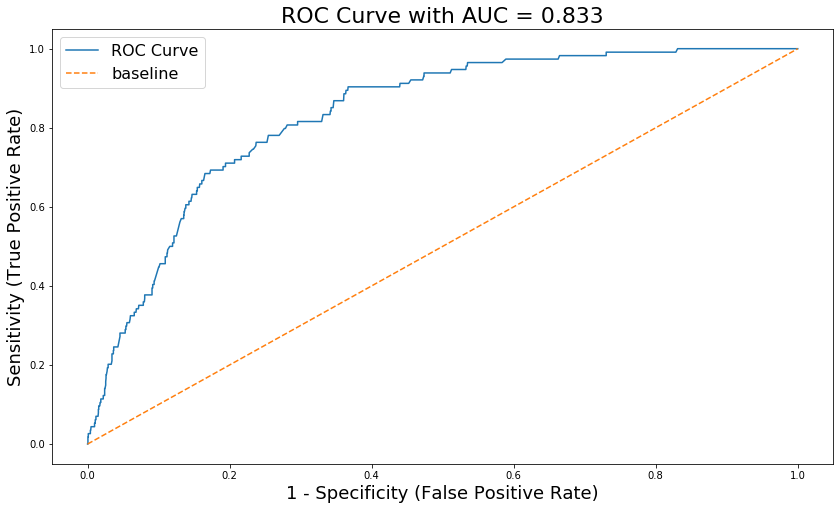

In [88]:
get_roc_curve(best_model , gboost_model['data']['X_test'],gboost_model['data']['y_test'] )

## Conclusion

 The best model selected is Gradient Boosting Classifier with the following parameters:
- gboost__learning_rate :0.1
- gboost__max_depth : 3
- gboost__n_estimators : 100
 
 Final 15 Polynomial Feature used:
- WetBulb Sunrise
- dateofyear WetBulb
- Sunrise Tmin
- dateofyear Tmax
- CULEX PIPIENS Tmin
- CULEX PIPIENS Tmax
- dateofyear Latitude
- dateofyear Longitude
- Latitude Sunrise
- Longitude Sunrise
- Latitude CULEX PIPIENS
- CULEX PIPIENS Sunset
- CULEX RESTUANS Sunset
- Longitude CULEX RESTUANS
- Latitude CULEX RESTUANS

With the data that's available, it provide us with sufficient information to produce a model that gives a good sense of whether WNV virus is occurring in a particular area. However, we might be able to give better predictions if we have more information of the following:
- Number of mosquitoes in the test data.
- Spray applied in rest of the years other than 2011 and 2013